In [1]:
# Dependencias Generales
import os
import gc
import nibabel as nib
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Dependencias de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

# Dependencias de Fastai
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.vision.models import resnet34
from fastai.losses import L1LossFlat # MAE Loss for flatten (lineal)
from fastai.metrics import mae, BalancedAccuracy, accuracy
from fastai.test_utils import *
from fastai.vision.all import *

from skimage.metrics import hausdorff_distance
from sklearn.metrics import recall_score

In [2]:
# Fijar la semilla de PyTorch
torch.manual_seed(42)

# Fijar la semilla de NumPy
np.random.seed(42)

### Preparación del encoder.

In [3]:
# Leer los dataFrames con las rutas y los datos
train = pd.read_csv('/kaggle/input/partition/trainAtlas.csv')
valid = pd.read_csv('/kaggle/input/partition/validAtlas.csv')
test = pd.read_csv('/kaggle/input/partition/testAtlas.csv')

In [4]:
standard_normalize = lambda array: (array - np.mean(array)) / np.std(array) if np.std(array) != 0 else array - np.mean(array)

In [5]:
class BraTS(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los paths de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    slice_num = self.atlas.iloc[index]['slice']

    # Obtener las imágenes de cada prueba 
    X = np.zeros((240, 240, 3))
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
      current_img = nib.load(img_path).dataobj[..., slice_num]       
      X[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(X.T).type(self.mri_dtype)
    y = torch.from_numpy(X.T).type(self.mri_dtype)
    
    del X
    del current_img

    return x, y

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)
    
class UpConvResize(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvResize, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=8, stride=1)
        )

    def forward(self, x):
        return self.block(x)

In [7]:
class ResidualAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResidualAutoencoder, self).__init__()
        
        self.encoder = nn.ModuleList([
            *list(resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).children())[:-2] # Tomar todas las capas excepto las últimas dos (avgpool y fc)
        ]) 

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder = nn.ModuleList([
            UpConvResize(1024, 512), #15
            UpConv(512, 256), #30
            UpConv(256, 128), #60
            UpConv(128, 64), #120
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )      
        
    def forward(self, x):
        o = x
        for layer in self.encoder:
            o = layer(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            o = layer(o)
            
        for layer in self.output:
            o = layer(o) 
            
        return o

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_BS = BraTS(train)
valid_BS = BraTS(valid)

train_dl = DataLoader(train_BS, batch_size=32, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_BS, batch_size=32, pin_memory=True)

autoencoder = ResidualAutoencoder().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 136MB/s] 


In [9]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(
    dls=dls,  
    model=autoencoder,      
    loss_func=L1LossFlat(),    
    metrics=[mae]
)

print(learn.summary())

ResidualAutoencoder (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU             

In [10]:
model_path = Path('/kaggle/input/encoder2/fittingautoencodertotrain')

# Cargar los pesos
learn.load(model_path)

## Segmentando Gliomas y Meningiomas

#### Redefinición de la clase de Dataset

In [11]:
class BraTS_SEG(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS_SEG, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32
    self.label_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los path de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    slice_num = self.atlas.iloc[index]['slice']

    brain_img = np.zeros((240, 240, 3))
    
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 3 pruebas
      current_img = nib.load(img_path).dataobj[..., slice_num]  
      brain_img[:, :, idx] += standard_normalize(current_img)
    
    # Obtener label
    label_path = img_paths[0].replace('t1c', 'seg')
    label = nib.load(label_path).dataobj[..., slice_num]
    
    # Binarizarlo mediante regla 'Whole Tumor'
    label_img = np.where(label != 0, 1, 0)
    
    x = torch.from_numpy(brain_img.T).type(self.mri_dtype)
    y = torch.from_numpy(label_img.T).type(self.mri_dtype)

    del brain_img
    del label
    del label_img
    del current_img

    return x, y

In [12]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, encoder_model=None):
        super(SegNet, self).__init__()
        
        # Encoder
        self.encoder = encoder_model.encoder
        
        # Representación latente
        self.bottleneck = encoder_model.bottleneck
    
        self.decoder = nn.ModuleList([
            UpConvResize(512+1024,512), #32
            UpConv(256+512,256), #64
            UpConv(128+256,128), #128
            UpConv(64+128,64) #256
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )
        
        
    def forward(self, x):
        skips = []
        o = x
        for i, layer in enumerate(self.encoder):
            o = layer(o)
            skips.append(o)
        
        o = self.bottleneck(o)
        
        for i, layer in enumerate(self.decoder):
            o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)
            
        for layer in self.output:
            o = layer(o)
            
        return o

In [13]:
train_SEG = BraTS_SEG(train)
valid_SEG = BraTS_SEG(valid)

train_dl = DataLoader(train_SEG, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_SEG, batch_size=32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seg_net = SegNet(encoder_model = learn.model).to(device)

### Definición de pérdida y métricas



In [14]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice

def dice_loss(inputs, targets):
    loss = DiceLoss()
    return loss(inputs, targets)

In [15]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn_seg = Learner(
    dls=dls,  
    model=seg_net,      
    loss_func=dice_loss,    
    metrics=[dice_loss]
)

print(learn_seg.summary())

SegNet (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                          

In [16]:
model_path = Path('/kaggle/input/segmentation/segmentation')

# Cargar los pesos
learn_seg.load(model_path)

### Resultados con toda la resonancia

In [17]:
def dice_similarity(inputs, targets, smooth=1e-6):
        """
        Calcula la pérdida de Dice para un par de tensores.

        Args:
        inputs (torch.Tensor): Tensor de predicciones.
        targets (torch.Tensor): Tensor de segmentaciones reales.
        smooth (float): Parámetro de suavizado para evitar divisiones por cero.

        Returns:
        float: Similaridad de Dice.
        """
        inputs = torch.sigmoid(inputs)  # Asegurarse de que las predicciones estén en el rango [0, 1]
        
        # Convertir las predicciones a binario (0 o 1) usando un umbral
        inputs = (inputs > 0.8).float()
        
        # Aplanar los tensores para facilitar el cálculo
        inputs_flat = inputs.reshape(-1)
        targets_flat = targets.reshape(-1)
        
        # Calcular la intersección y la suma de las predicciones y los objetivos
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2.0 * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        return dice_score.item()

def postprocessing(inputs):
    inputs = torch.sigmoid(inputs)  
    inputs = (inputs > 0.8).float()
    return inputs.numpy()
    
def sensibilidad(inputs, targets):
    inputs = torch.sigmoid(inputs) 
    inputs = (inputs > 0.8).float()
        
    inputs_flat = inputs.reshape(-1)
    targets_flat = targets.reshape(-1)
    
    return recall_score(targets_flat, inputs_flat, zero_division=0.0)

In [18]:
def check_one(paths_resonancias):
    
    """
     Dado tres resonancias completas da la predicción final.
     Aplica el modelo iterativamente por cada 3-slice de las resonancias y calcula las métricas de estas.
     Devuelve la media de las metricas de todos los slices
    """
    # Traer las tres resonancias 
    t1c = nib.load(paths_resonancias[0]).get_fdata()
    t1n = nib.load(paths_resonancias[1]).get_fdata()
    t2f = nib.load(paths_resonancias[2]).get_fdata()
    
    # Traer la etiqueta
    label_path = paths_resonancias[0].replace('t1c', 'seg')
    label = nib.load(label_path).get_fdata()

    # Binarizarlo mediante regla 'Whole Tumor'
    Y = np.where(label != 0, 1, 0)
    
    # Combinarlas
    X = np.zeros((155, 3, 240, 240))
    for i in range(155): # Combinar cada slice de las 3 pruebas en 3 canales  
      X[i, 0, :, :] += standard_normalize(t1c[:, :, i])
      X[i, 1, :, :] += standard_normalize(t1n[:, :, i])
      X[i, 2, :, :] += standard_normalize(t2f[:, :, i])
    
    # Inferir todos los slices con la red
    X = torch.from_numpy(X).type(torch.float32)
    Y = torch.from_numpy(Y).type(torch.float32)
    
    pred, _ = learn_seg.get_preds(dl=[(X,)])
    pred = pred.squeeze(1) # Quitar la dimensión agregada por get_preds
    
    dice_mean = 0
    distanciaH = 0
    recall_mean = 0
    num_segmentos = 1
    for i in range(0, 155):
        dice_mean += dice_similarity(inputs = pred[i, :, :], targets = Y[:, :, i])
        # Solo si la imagen tiene segmentación se calcula la distancia de Hausdorff
        if  torch.any(Y[:, :, i] == 1):
            distancia_h_actual = hausdorff_distance(postprocessing(pred[i, :, :]), Y[:, :, i].numpy())
            recall_mean += sensibilidad(inputs = pred[i, :, :], targets = Y[:, :, i])
            num_segmentos += 1
            
            if not math.isinf(distancia_h_actual):
                distanciaH += distancia_h_actual
                
            
    return dice_mean / 155, distanciaH / num_segmentos, recall_mean / num_segmentos

In [23]:
def check(df: pd.DataFrame):
    # Obtener los valores únicos de esas columnas
    valores_unicos = df[['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].drop_duplicates().values
    
    # Para todos los ejemplos del conjunto
    dice = 0
    distH = 0
    recall = 0
    
    # Inicializar listas para guardar los valores
    dice_scores = []
    hausdorff_distances = []
    sensitivities = []
    
    for instancia in valores_unicos:
        diceI, distHI, recallI = check_one(instancia)
        dice_scores.append(diceI)
        hausdorff_distances.append(distHI)
        sensitivities.append(recallI)
        dice += diceI
        distH += distHI
        recall += recallI
        
    # Crear las gráficas
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Gráfica para Similaridad Dice
    axes[0].hist(dice_scores, bins=100, color='b', alpha=0.7)
    axes[0].set_title('Distribución de Similaridad Dice')
    axes[0].set_xlabel('Similaridad Dice')
    axes[0].set_ylabel('Cantidad')

    # Gráfica para Distancia Hausdorff
    axes[1].hist(hausdorff_distances, bins=100, color='g', alpha=0.7)
    axes[1].set_title('Distribución de Distancia Hausdorff')
    axes[1].set_xlabel('Distancia Hausdorff')
    axes[1].set_ylabel('Cantidad')

    # Gráfica para Sensibilidad
    axes[2].hist(sensitivities, bins=100, color='r', alpha=0.7)
    axes[2].set_title('Distribución de Sensibilidad')
    axes[2].set_xlabel('Sensibilidad')
    axes[2].set_ylabel('Cantidad')

    # Ajustar el layout para que no se solapen las gráficas
    plt.tight_layout()

    # Mostrar las gráficas
    plt.show()
        
    return dice / len(valores_unicos), distH / len(valores_unicos), recall / len(valores_unicos)

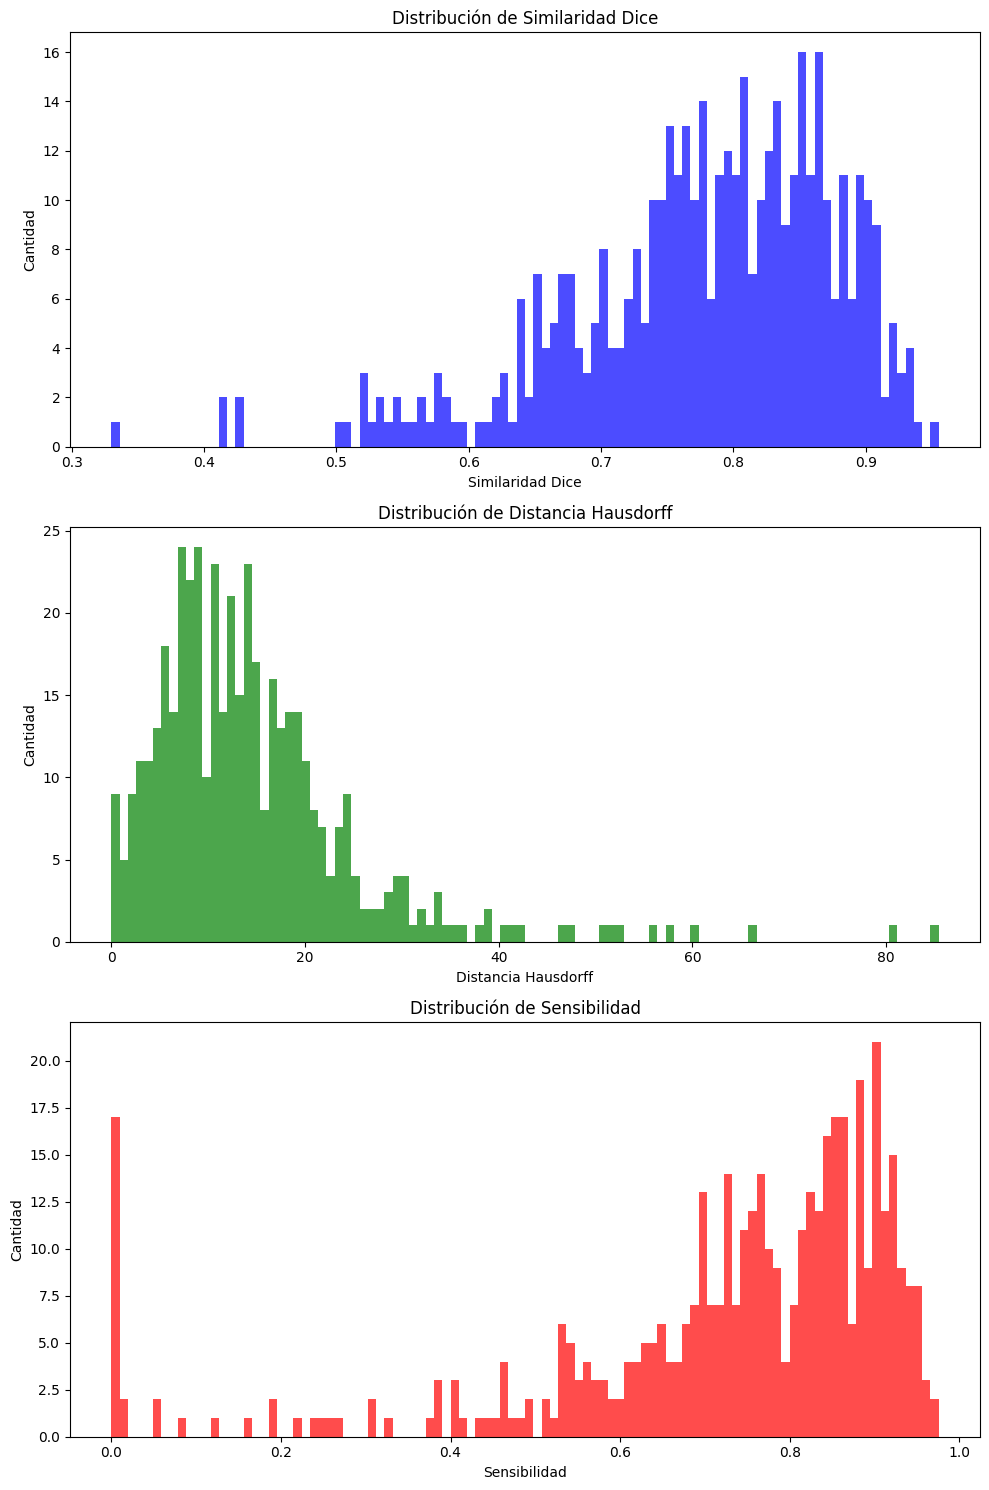

In [24]:
dice_val, haus_val, recall_val = check(valid)

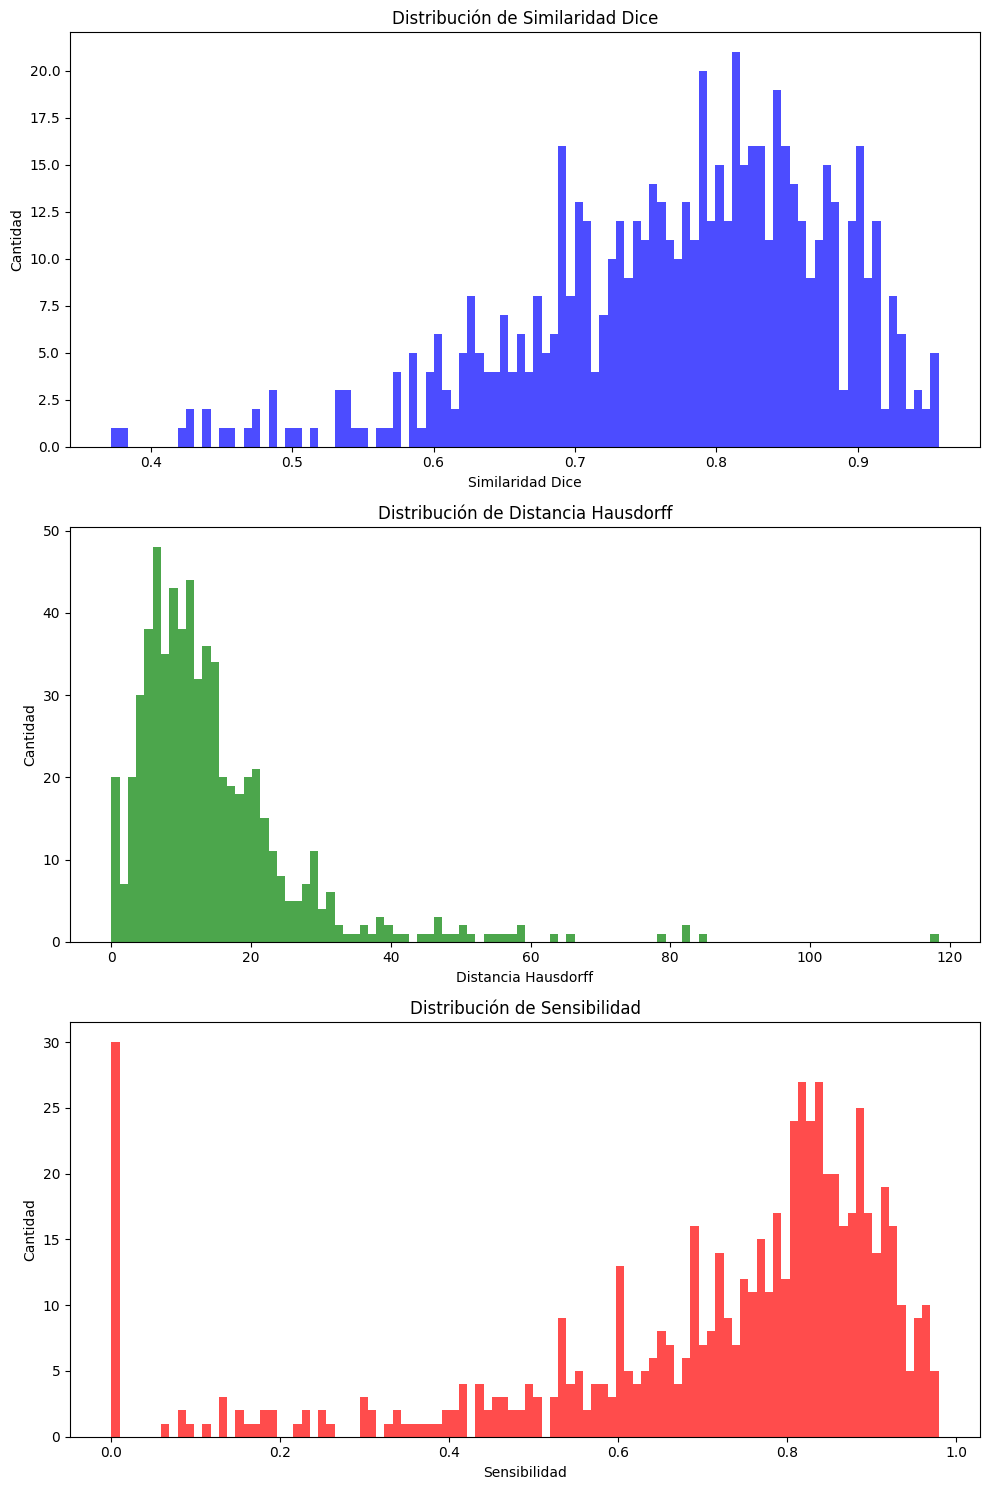

In [25]:
dice_test, haus_test, recall_test = check(test)

In [27]:
# Crear un DataFrame con los resultados
resultados = {
    'Conjunto de datos': ['Validación', 'Test'],
    'Similaridad Dice': [dice_val, dice_test],
    'Distancia de Hausdorff': [haus_val, haus_test],
    'Sensibilidad':[recall_val, recall_test]
}

tabla_resultados = pd.DataFrame(resultados)

# Mostrar el DataFrame
display(tabla_resultados)

,Conjunto de datos,Similaridad Dice,Distancia de Hausdorff,Sensibilidad
0,Validación,0.777343,14.573561,0.720415
1,Test,0.772642,14.577154,0.709075
